# Hierarchical Multi-Agent Teams

- Author: [Harheem Kim](https://github.com/harheem)
- Design:
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/08-Hierarchical-Multi-Agent-Teams.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/08-Hierarchical-Multi-Agent-Teams.ipynb)

## Overview
In this tutorial, we'll explore how to build a **Hierarchical Agent Team**.

We'll implement a hierarchical structure to break down complex tasks that are difficult to handle with a single agent or single-level supervisor. In this structure, each lower-level supervisor manages worker agents specialized in their respective domains.

This hierarchical approach helps efficiently solve complex tasks that would be overwhelming for a single worker or when there are too many workers to manage directly.

This example implements ideas from the [AutoGen paper](https://arxiv.org/abs/2308.08155) using `LangGraph`, demonstrating how to organize two distinct teams for web research and document writing, managed through top and mid-level supervisors to oversee the entire process.

### Why Choose a **Hierarchical Agent Team**?

In our previous Supervisor example, we looked at how a single supervisor node assigns tasks to multiple worker nodes and consolidates their results. While this approach works well for simple cases, a hierarchical structure might be necessary in the following situations:

- **Increased Task Complexity**: A single supervisor may not be able to handle specialized knowledge required across various sub-domains simultaneously.
- **Growing Number of Workers**: When managing many workers, having a single supervisor directly command all workers can become overwhelming.

In such scenarios, we can create a hierarchical structure where higher-level supervisors delegate tasks to lower-level sub-supervisors, and each sub-supervisor then redistributes these tasks to their specialized worker teams.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Building Tools](#building-tools)
- [Implementing Utility Functions for Multiple Agents](#implementing-utility-functions-for-multiple-agents)
- [Defining Agent Teams](#defining-agent-teams)
- [Structuring a Super-Graph](#structuring-a-super-graph)

### References
- [AutoGen paper: Enabling Next-Gen LLM Applications via Multi-Agent Conversation (Wu et al.)](https://arxiv.org/abs/2308.08155)
- [LangGraph - Multi-agent Systems](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)

----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials.
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install -U langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain_community",
        "langchain_openai",
        "langchain_core",
        "langchain_experimental",
        "langgraph",
        "beautifulsoup4",
    ],
    verbose=False,
    upgrade=False,
)

`LangChain` provides built-in tools that make it easy to use the `Tavily` search engine as a tool in your applications.

To use `Tavily Search`, you'll need to obtain an API key.

Click [here](https://app.tavily.com/sign-in) to sign up on the `Tavily` website and get your `Tavily Search` API key.

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "TAVILY_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Hierarchical-Multi-Agent-Teams",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys in a `.env` file and load it.

[Note] This is not necessary if you've already set API keys in previous steps.

In [ ]:
from dotenv import load_dotenv

# Load API key information
load_dotenv(override=True)

## Building Tools

Each team consists of one or more agents, and each agent is equipped with one or more tools. Below, we'll define all the tools that will be used by various teams.
Let's first look at the research team.

### ResearchTeam Tools

The ResearchTeam can use search engines and URL scrapers to find information on the web. You can freely add additional features below to enhance the ResearchTeam's performance.

In [ ]:
import re
from typing import List
from bs4 import BeautifulSoup
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

# Define search tool (TavilySearch)
# Create a search tool instance that returns up to 6 results
tavily_tool = TavilySearchResults(k=6)


# Define tool for scraping detailed information from web pages
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    # Load web pages using the provided URL list
    loader = WebBaseLoader(
        web_path=urls,
        header_template={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
        },
    )
    docs = loader.load()
    
    def clean_text(html: str) -> str:
        soup = BeautifulSoup(html, "html.parser")
        text = soup.get_text(separator=" ").strip()
        return re.sub(r'\s+', ' ', text)  # Remove excessive whitespace
    
    # Create a string containing titles and content of loaded documents
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "").strip()}">\n{clean_text(doc.page_content)}\n</Document>'
            for doc in docs
        ]
    )

### Document Writing Team Tools

Next, we'll define the tools (file access tools) that the document writing team will use.
These tools allow agents to access the file system, which may not be secure. Therefore, caution is needed when using them.

In [6]:
from pathlib import Path
from typing import Dict, Optional, List
from typing_extensions import Annotated

# Create temporary directory and set working directory
WORKING_DIRECTORY = Path("./tmp")

# Create tmp folder if it doesn't exist
WORKING_DIRECTORY.mkdir(exist_ok=True)


# Create and save outline
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# Read document
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


# Write and save document
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


# Edit document
@tool
def edit_document(
    file_name: Annotated[str, "File path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "File path of the edited document."]:
    """Edit a document by inserting text at specific line numbers."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    # Process insertions in order
    sorted_inserts = sorted(inserts.items())

    # Insert text at specified line numbers
    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    # Save edited document to file
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

Finally, let's define the code execution tool, `PythonREPLTool`:

In [7]:
from langchain_experimental.tools import PythonREPLTool

# PythonREPL tool
python_repl_tool = PythonREPLTool()

## Implementing Utility Functions for Multiple Agents
Here's how we create utility functions to streamline our tasks.

We'll use the `functools.partial` function from our previous tutorial to create agent nodes, specifically for:

1. Creating `worker agents`
2. Creating `supervisors` for `sub-graphs`

In [8]:
from langgraph.graph import START, END
from langchain_core.messages import HumanMessage
from langchain_openai.chat_models import ChatOpenAI


# Agent Factory Class
class AgentFactory:
    def __init__(self, model_name):
        self.llm = ChatOpenAI(model=model_name, temperature=0)

    def create_agent_node(self, agent, name: str):
        # Node creation function
        def agent_node(state):
            result = agent.invoke(state)
            return {
                "messages": [
                    HumanMessage(content=result["messages"][-1].content, name=name)
                ]
            }

        return agent_node


# Initialize LLM
MODEL_NAME = "gpt-4o-mini"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Create Agent Factory instance
agent_factory = AgentFactory(MODEL_NAME)

Here's an example of creating an agent node using the `AgentFactory`. Let's look at how to create a search agent:

In [9]:
from langgraph.prebuilt import create_react_agent

# Define agent
search_agent = create_react_agent(llm, tools=[tavily_tool])
# Create agent node
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

Next is the function for creating a Team Supervisor:

In [10]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal


def create_team_supervisor(model_name, system_prompt, members) -> str:
    # Define list of options for next worker
    options_for_next = ["FINISH"] + members

    # Define response model for worker selection
    class RouteResponse(BaseModel):
        next: Literal[*options_for_next]

    # Create ChatPromptTemplate
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next? "
                "Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options_for_next))

    # Initialize LLM
    llm = ChatOpenAI(model=model_name, temperature=0)

    # Combine prompt and LLM to create chain
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    return supervisor_chain

## Defining Agent Teams
Let's define the Research Team and Doc Writing Team.

### Research Team

The research team has two worker nodes: a `search agent` and a `research_agent` responsible for `web scraping`. Let's create these and set up their team supervisor:

In [11]:
import operator
from typing import List, TypedDict
from typing_extensions import Annotated

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# Define state
class ResearchState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]  # Messages
    team_members: List[str]  # List of member agents
    next: str  # Instructions for Supervisor agent to select next worker


# Initialize LLM
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Create search node
search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

# Create web scraping node
web_scraping_agent = create_react_agent(llm, tools=[scrape_webpages])
web_scraping_node = agent_factory.create_agent_node(
    web_scraping_agent, name="WebScraper"
)

# Create Supervisor agent
supervisor_agent = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Searcher", "WebScraper"],
)

Finally, let's define a function to select the next node for routing:

In [12]:
def get_next_node(x):
    return x["next"]

### Creating Research Team Graph

Creates a workflow where a supervisor coordinates web search and scraping tasks.

In [13]:
from langchain_opentutorial.graphs import visualize_graph
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

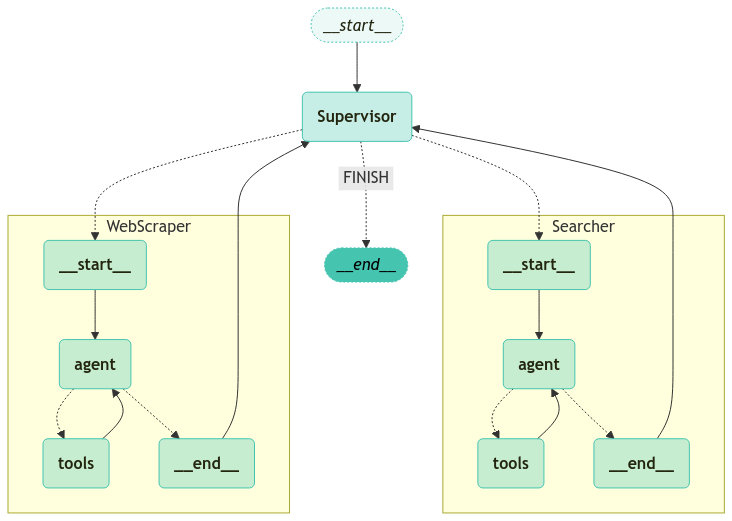

In [14]:
# Create graph
web_research_graph = StateGraph(ResearchState)

# Add nodes
web_research_graph.add_node("Searcher", search_node)
web_research_graph.add_node("WebScraper", web_scraping_node)
web_research_graph.add_node("Supervisor", supervisor_agent)

# Add edges
web_research_graph.add_edge("Searcher", "Supervisor")
web_research_graph.add_edge("WebScraper", "Supervisor")

# Define conditional edges: move to next node based on Supervisor's decision
web_research_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {"Searcher": "Searcher", "WebScraper": "WebScraper", "FINISH": END},
)

# Set entry point
web_research_graph.set_entry_point("Supervisor")

# Compile graph
web_research_app = web_research_graph.compile(checkpointer=MemorySaver())

# Visualize graph
visualize_graph(web_research_app, xray=True)

Let's run the `web_research_app`:

In [15]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import random_uuid, invoke_graph


def run_graph(app, message: str, recursive_limit: int = 50):
    # Set configuration
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # Prepare input
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    # Execute graph and display output
    invoke_graph(app, inputs, config)

    return app.get_state(config).values

In [16]:
output = run_graph(
    web_research_app,
    "Please summarize the main news from https://finance.yahoo.com/ and include the sources (URLs).",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
WebScraper

🔄 Node: agent in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  scrape_webpages (call_ASFYUuM6HWrcZu0sqXoBDoCI)
 Call ID: call_ASFYUuM6HWrcZu0sqXoBDoCI
  Args:
    urls: ['https://finance.yahoo.com/']

🔄 Node: tools in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: scrape_webpages

<Document name="Yahoo Finance - Stock Market Live, Quotes, Business & Finance News">
Yahoo Finance - Stock Market Live, Quotes, Business & Finance News News Today's news US Politics World Tech Reviews and deals Audio Computing Gaming Health Home Phones Science TVs Climate change Health Science Originals The 360 Newsletters Life Health COVID-19 Fall allergies Health news Mental health Relax Sexual health

In [17]:
# Print final result
print(output["messages"][-1].content)

Here are the main news highlights from Yahoo Finance:

1. **Trump Delays Tariffs on Canada and Mexico**: President Trump has agreed to delay the implementation of tariffs on Canada and Mexico, as both countries committed to sending more resources to their borders. However, tariffs on China are still set to take effect soon. [Source](https://finance.yahoo.com)

2. **Impact of Tariffs on Big Tech**: Analysts warn that Trump's 10% tariffs on China could significantly impact major technology companies. [Source](https://finance.yahoo.com)

3. **Palantir's Revenue Forecast**: Palantir Technologies saw a surge in its stock price following an optimistic revenue forecast driven by strong demand for AI solutions. [Source](https://finance.yahoo.com)

4. **Market Reactions**: Futures for the Dow, S&P 500, and Nasdaq rose after the announcement of the tariff delays. [Source](https://finance.yahoo.com)

5. **Target Faces Lawsuit**: Target is being sued for allegedly defrauding shareholders regarding

### Document Writing Team
Now let's create the document writing team. Here, we'll grant different file-writing tool access to each agent.

In [18]:
import operator
from typing import List, TypedDict, Annotated
from pathlib import Path

# Create temporary directory and set working directory
WORKING_DIRECTORY = Path("./tmp")
WORKING_DIRECTORY.mkdir(exist_ok=True)  # Create tmp folder if it doesn't exist


# Define state
class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str  # Currently working files


# State preprocessing node: Helps each agent better recognize current working directory state
def preprocess(state):
    # Initialize list of written files
    written_files = []

    try:
        # Search all files in working directory and convert to relative paths
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass

    # Add "No files written." to state if no files exist
    if not written_files:
        return {**state, "current_files": "No files written."}

    # Add list of written files to state
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


# Initialize LLM
llm = ChatOpenAI(model=MODEL_NAME)

# Create document writing agent
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    state_modifier="You are a arxiv researcher. Your mission is to write arxiv style paper on given topic/resources.",
)
context_aware_doc_writer_agent = preprocess | doc_writer_agent
doc_writing_node = agent_factory.create_agent_node(
    context_aware_doc_writer_agent, name="DocWriter"
)

# Create note taking node
note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    state_modifier="You are an expert in creating outlines for research papers. Your mission is to create an outline for a given topic/resources or documents.",
)
context_aware_note_taking_agent = preprocess | note_taking_agent
note_taking_node = agent_factory.create_agent_node(
    context_aware_note_taking_agent, name="NoteTaker"
)

# Create chart generating agent
chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)
context_aware_chart_generating_agent = preprocess | chart_generating_agent
chart_generating_node = agent_factory.create_agent_node(
    context_aware_chart_generating_agent, name="ChartGenerator"
)

# Create document writing team supervisor
doc_writing_supervisor = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: ['DocWriter', 'NoteTaker', 'ChartGenerator']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

### Creating Doc Writing Team Graph

Integrates document writing, note-taking, and chart generation into a unified flow.

In [19]:
# Create graph
authoring_graph = StateGraph(DocWritingState)

# Define nodes
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("Supervisor", doc_writing_supervisor)

# Define edges
authoring_graph.add_edge("DocWriter", "Supervisor")
authoring_graph.add_edge("NoteTaker", "Supervisor")
authoring_graph.add_edge("ChartGenerator", "Supervisor")

# Define conditional edges: Move to next node based on Supervisor node's decision
authoring_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

# Set entry point
authoring_graph.set_entry_point("Supervisor")

# Compile graph
authoring_app = authoring_graph.compile(checkpointer=MemorySaver())

Let's visualize the graph:

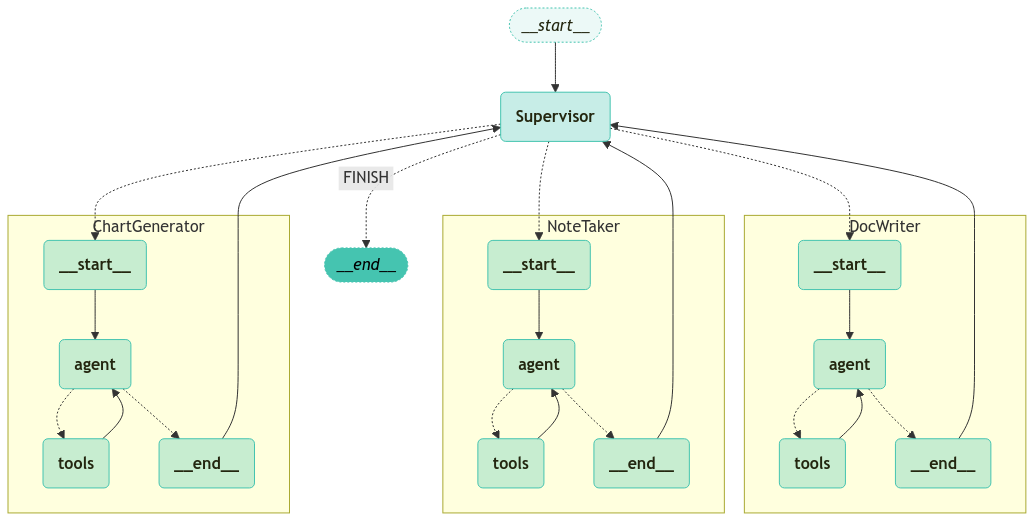

In [20]:
# Visualize graph
visualize_graph(authoring_app, xray=True)

Now, let's run the graph and check the results:

In [21]:
output = run_graph(
    authoring_app,
    "Please do an in-depth analysis of the Transformer architecture and create a table of contents."
    "Then write at least 5 sentences for each section. "
    "If charts are needed for detailed explanations, please create them. "
    "Save the final results. ",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
DocWriter

🔄 Node: agent in [DocWriter] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  write_document (call_Gzcvkmtplu3XA7U4O17i5u5F)
 Call ID: call_Gzcvkmtplu3XA7U4O17i5u5F
  Args:
    content: # In-Depth Analysis of the Transformer Architecture

## Table of Contents
1. Introduction  
2. Background  
3. Transformer's Architecture  
   3.1. Multi-Head Attention  
   3.2. Position-wise Feed-Forward Networks  
   3.3. Positional Encoding  
4. Training the Transformer  
   4.1. Loss Functions  
   4.2. Optimization Techniques  
5. Applications of Transformer Architecture  
   5.1. Natural Language Processing  
   5.2. Computer Vision  
   5.3. Speech Recognition  
6. Conclusion  

## 1. Introduction  
The Transformer architecture has revolutionized the field of machine learning, particularly in natural language 


🔄 Node: agent in [ChartGenerator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (call_efCveTCHpS0U6p3XhW7X5Egy)
 Call ID: call_efCveTCHpS0U6p3XhW7X5Egy
  Args:
    query: import datetime

datetime.datetime.now().isoformat()

🔄 Node: tools in [ChartGenerator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: Python_REPL



🔄 Node: agent in [ChartGenerator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

The analysis of the Transformer architecture has been completed successfully. Here is the table of contents included in the document:

### Table of Contents
1. Introduction to Transformer Architecture
2. Key Components of Transformer
   - 2.1 Multi-Head Self-Attention
   - 2.2 Position-wise Feed-Forwa

## Structuring a Super-Graph

This design implements a bottom-up planning policy. Although we've already created two graphs, we need to determine how to route tasks between them.

For this purpose, we'll define a **Super-Graph** to coordinate these two existing graphs and add connecting elements that define how this higher-level state is shared between different graphs. First, let's create the chief supervisor node:

In [22]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

# Create ChatOpenAI instance as the base LLM
llm = ChatOpenAI(model=MODEL_NAME)

# Create team supervisor node
supervisor_node = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: ['ResearchTeam', 'PaperWritingTeam']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

Next, we'll define the state and nodes of the Super-Graph.

The Super-Graph primarily serves to route tasks between teams.

In [23]:
from typing import TypedDict, List, Annotated
import operator


# Define state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    # Routing decision
    next: str


# Node for returning the last message
def get_last_message(state: State) -> str:
    last_message = state["messages"][-1]
    if isinstance(last_message, str):
        return {"messages": [HumanMessage(content=last_message)]}
    else:
        return {"messages": [last_message.content]}


# Node for consolidating responses
def join_graph(response: dict):
    # Extract the last message and return as a message list
    return {"messages": [response["messages"][-1]]}

### Defining the Super-Graph

Now, let's define a Super-Graph that connects the two teams.

In [24]:
# Define graph
super_graph = StateGraph(State)

# Define nodes
super_graph.add_node("ResearchTeam", get_last_message | web_research_app | join_graph)
super_graph.add_node("PaperWritingTeam", get_last_message | authoring_app | join_graph)
super_graph.add_node("Supervisor", supervisor_node)

# Define edges
super_graph.add_edge("ResearchTeam", "Supervisor")
super_graph.add_edge("PaperWritingTeam", "Supervisor")

# Add conditional edges: Move to next node based on Supervisor's decision
super_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)

# Set Supervisor node as the entry point
super_graph.set_entry_point("Supervisor")

# Compile graph
super_graph = super_graph.compile(checkpointer=MemorySaver())

Let's visualize the graph:

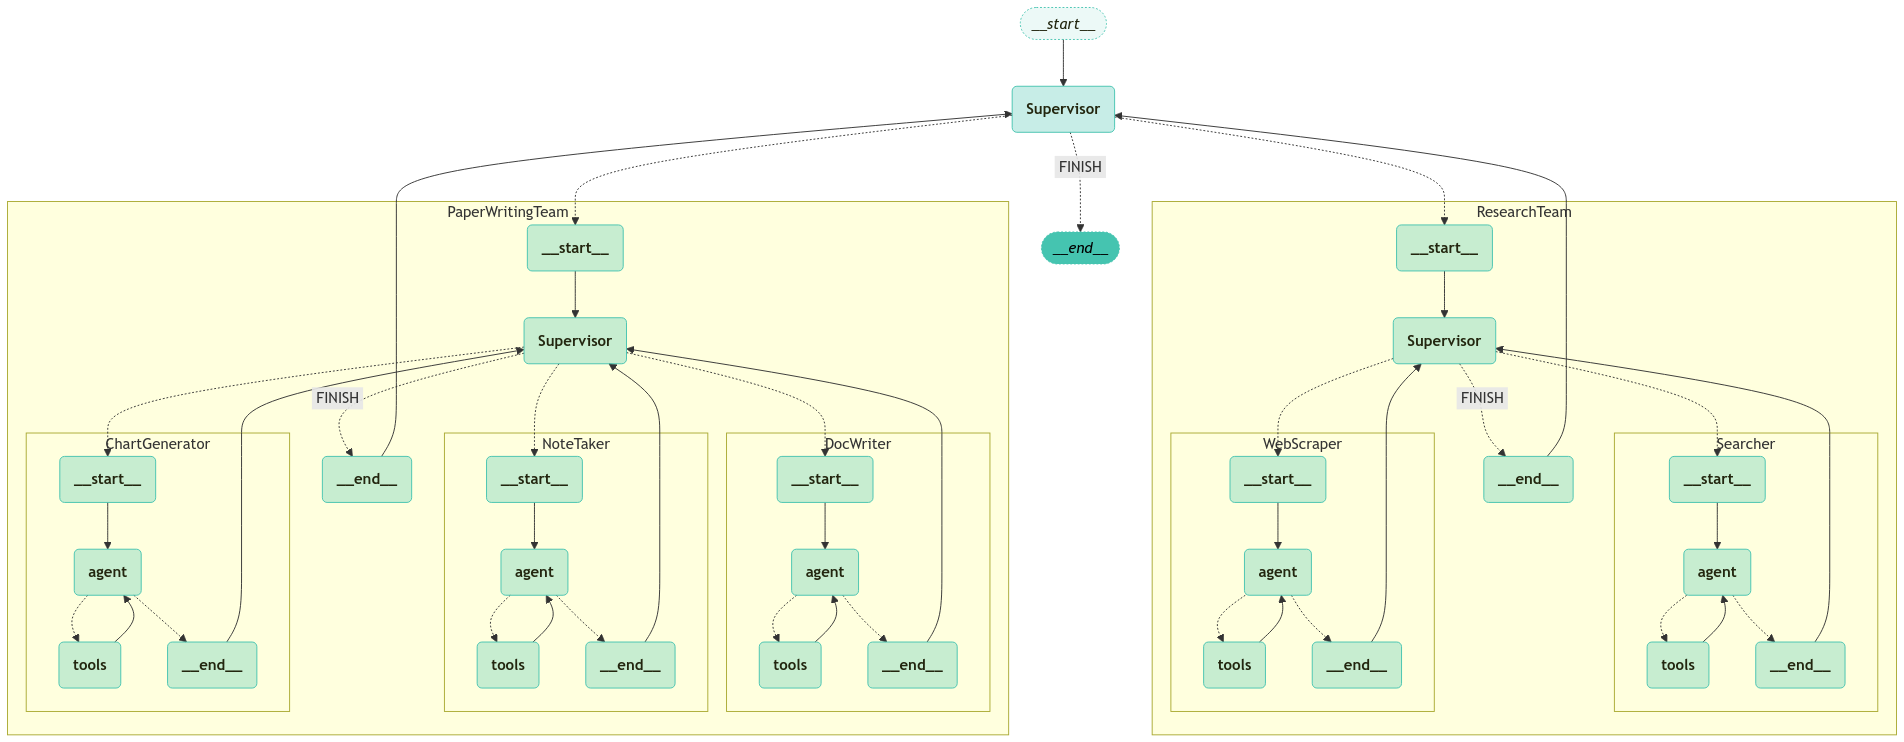

In [25]:
# Visualize graph
visualize_graph(super_graph, xray=True)

In [27]:
output = run_graph(
    super_graph,
    """Topic: How to perform complex tasks using multi-agent architecture

Detailed guidelines:
- Generate a report in Arxiv paper format on the topic.
- Create a comprehensive outline that covers all major aspects of the topic, such as introduction, background, methodology, applications, challenges, and conclusions.
- For each section of the outline, write at least 5 detailed sentences that explain the key concepts, theories, and practical applications involved.
- Ensure that for sections where applicable, you create and add charts or diagrams that help clarify complex ideas, such as relationships between agents, tasks, and processes.
- Provide detailed explanations on how multi-agent architecture can be used to solve real-world complex tasks, and include relevant examples and case studies where possible.
- Cite academic papers, articles, and other reliable sources in APA format throughout the content.
- Ensure each section is written in full (not just the outline) and the final document contains substantial content in line with the requested guidelines.
- Save the final result as a .md file with all the content fully populated, including the references section in APA format at the end.
""",
    recursive_limit=150,
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
ResearchTeam

🔄 Node: Supervisor in [ResearchTeam] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Searcher

🔄 Node: agent in [Searcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_QoPI1KdwQJeLRDkdDDwAUqef)
 Call ID: call_QoPI1KdwQJeLRDkdDDwAUqef
  Args:
    query: multi-agent architecture complex tasks report

🔄 Node: tools in [Searcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.dragonscale.ai/architectures-for-ai-agents/", "content": "AI agents are systems capable of reasoning, planning, and executing tasks autonomously. MAS involve multiple agents, each potentially equipped with different language models and tools

Display the final result in Markdown format:

In [28]:
# Check the filename generated by the execution in the directory, and update the `md_file` variable below accordingly.
from IPython.display import Markdown

md_file = (
    "tmp/multi_agent_architecture_report.md"  # Update the filename here if necessary.
)
with open(md_file, "r", encoding="utf-8") as f:
    display(Markdown(f.read()))

# Report on Multi-Agent Architecture for Complex Task Execution

## Outline

1. **Introduction**  
   - Definition of multi-agent systems (MAS) and their significance in solving complex tasks.  
   - Overview of the evolution of MAS and their applications in various fields.  
   - Importance of collaboration among agents in achieving task objectives.  
   - Brief mention of the structure of the report and what each section will cover.  
   - Statement of the report's objectives and the relevance of the topic in current research.

2. **Background**  
   - Historical context of multi-agent systems and their development.  
   - Key concepts in MAS, including agent autonomy, communication, and cooperation.  
   - Overview of different types of agents and their roles in MAS.  
   - Discussion of the theoretical frameworks that underpin MAS, such as game theory and distributed systems.  
   - Summary of existing literature and research on MAS applications.

3. **Methodology**  
   - Description of the design and implementation of a multi-agent architecture.  
   - Explanation of task decomposition and agent specialization.  
   - Overview of communication protocols and mechanisms used in MAS.  
   - Discussion of evaluation metrics for assessing the performance of MAS.  
   - Case studies illustrating the application of the methodology in real-world scenarios.

4. **Applications**  
   - Exploration of various domains where MAS can be applied, such as robotics, healthcare, and smart cities.  
   - Detailed examples of successful MAS implementations in industry and research.  
   - Discussion of how MAS can enhance efficiency and effectiveness in complex task execution.  
   - Analysis of the role of MAS in emerging technologies, such as AI and IoT.  
   - Future trends and potential areas for further research in MAS applications.

5. **Challenges**  
   - Identification of common challenges faced in the development and deployment of MAS.  
   - Discussion of issues related to agent coordination, communication, and conflict resolution.  
   - Examination of ethical considerations and safety concerns in MAS.  
   - Overview of technical limitations and scalability issues.  
   - Strategies for overcoming these challenges and improving MAS performance.

6. **Conclusions**  
   - Summary of key findings from the report.  
   - Reflection on the significance of multi-agent architecture in solving complex tasks.  
   - Recommendations for future research directions in MAS.  
   - Final thoughts on the potential impact of MAS on society and technology.  
   - Call to action for researchers and practitioners to explore MAS further.

## Detailed Content

### 1. Introduction  

Multi-agent systems (MAS) are defined as systems composed of multiple interacting intelligent agents, capable of autonomous decision-making and task execution. The significance of MAS lies in their ability to collaboratively solve complex tasks that are beyond the capabilities of individual agents. Over the years, MAS have evolved from simple rule-based systems to sophisticated architectures that leverage advanced algorithms and machine learning techniques. The collaboration among agents is crucial, as it allows for the distribution of tasks, parallel processing, and the pooling of resources and knowledge. This report aims to provide a comprehensive overview of multi-agent architecture, focusing on its methodology, applications, challenges, and future directions.

### 2. Background  

The historical context of multi-agent systems dates back to the early days of artificial intelligence, where researchers began exploring the potential of autonomous agents. Key concepts in MAS include agent autonomy, which refers to the ability of agents to operate independently, and communication, which is essential for coordination among agents. Different types of agents, such as reactive, deliberative, and hybrid agents, play distinct roles in MAS, contributing to their overall functionality. Theoretical frameworks, including game theory and distributed systems, provide the foundation for understanding agent interactions and decision-making processes. A review of existing literature reveals a growing interest in MAS applications across various domains, highlighting their versatility and effectiveness.

### 3. Methodology  

The design and implementation of a multi-agent architecture involve several key steps, including task decomposition, where complex tasks are broken down into manageable subtasks assigned to specialized agents. Communication protocols, such as publish-subscribe mechanisms, facilitate information exchange among agents, ensuring that they remain informed about relevant developments. Evaluation metrics, such as task completion time and resource utilization, are essential for assessing the performance of MAS. Case studies, such as the deployment of MAS in disaster response scenarios, illustrate the practical application of these methodologies, showcasing how agents can work together to achieve common goals.

### 4. Applications  

Multi-agent systems have found applications in diverse fields, including robotics, where they enable coordinated movements of robotic swarms, and healthcare, where they assist in patient monitoring and treatment planning. Successful implementations, such as autonomous vehicles and smart grid management, demonstrate the potential of MAS to enhance efficiency and effectiveness in complex task execution. The integration of MAS with emerging technologies, such as the Internet of Things (IoT) and artificial intelligence (AI), opens new avenues for innovation and problem-solving. Future trends indicate a growing reliance on MAS in various sectors, driven by the need for intelligent and adaptive systems.

### 5. Challenges  

Despite their advantages, the development and deployment of multi-agent systems face several challenges. Coordination among agents can be difficult, especially in dynamic environments where tasks and conditions change rapidly. Communication issues, such as information overload and misinterpretation, can hinder agent collaboration. Ethical considerations, including privacy and security concerns, must be addressed to ensure responsible use of MAS. Technical limitations, such as scalability and computational complexity, pose additional hurdles. Strategies for overcoming these challenges include the development of robust algorithms, improved communication protocols, and ethical guidelines for agent behavior.

### 6. Conclusions  

In conclusion, multi-agent architecture represents a powerful approach to solving complex tasks through collaboration and autonomy. The findings of this report highlight the significance of MAS in various applications and the potential for future research to address existing challenges. As technology continues to evolve, the impact of MAS on society and industry will likely grow, necessitating further exploration and innovation in this field. Researchers and practitioners are encouraged to delve deeper into the capabilities of MAS, fostering advancements that can lead to more efficient and effective solutions to real-world problems.

## References

- Fourney, A., Bansal, G., Mozannar, H., Dibia, V., & Amershi, S. (2024). Magentic-One: A Generalist Multi-Agent System for Solving Complex Tasks. *Microsoft Research*. Retrieved from [Microsoft Research](https://www.microsoft.com/en-us/research/articles/magentic-one-a-generalist-multi-agent-system-for-solving-complex-tasks/)
- Sharifi, N. (2024). Building a Multi-Agent System to Accomplish Complex Tasks. *Towards AI*. Retrieved from [Towards AI](https://pub.towardsai.net/building-a-multi-agent-system-to-accomplish-complex-tasks-812aeedda4eb)
- Pimentel, S. (2024). Architectures for AI Agents: From Basic to Multi-Agent Systems. *DragonScale AI Blog*. Retrieved from [DragonScale AI](https://blog.dragonscale.ai/architectures-for-ai-agents/)